In [1]:
# Generate the data
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import trange
from pathlib import Path
import matplotlib.pyplot as plt       # histograms, QQ plots, etc.
import pickle


def generate_xy_equally_spaced(n=10000):
    random.seed(42) 

    x = np.linspace(0, 1, n)
    random.shuffle(x)  # shuffle the x values to ensure randomness
    # y = np.exp(x)
    y = x**2
    return x, y


In [2]:
# model (TensorFlow 2 / Keras)
def make_model(seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='sigmoid'),
        tf.keras.layers.Dense(2, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=["mae"])
    return model


In [12]:
# Training
def train_many(n_runs=1000, n_samples=10000, epochs=100, inverse=False):
    weight_rows, bias_rows, error_all = [], [], []
    
    bar = trange(
        n_runs,
        desc="Inverse runs" if inverse else "Forward runs",
        unit="run"
    )
    
    for seed in bar:                    
        tf.keras.backend.clear_session()

        x, y = generate_xy_equally_spaced(n_samples)
        if inverse:
            x, y = y, x
            
    # for seed in trange(n_runs, desc=f"{'Inverse' if inverse else 'Forward'} runs"):
    #     tf.keras.backend.clear_session()
    #     x, y = generate_xy_equally_spaced(n_samples)
    #     if inverse:
    #         x, y = y, x

        split = int(0.8 * n_samples)
        x_train, x_test = x[:split], x[split:]
        y_train, y_test = y[:split], y[split:]
        
# --- build the model ---
        model = make_model(seed = seed)
        # print(f"Training model with seed {seed} on {n_samples} samples for {epochs} epochs")
        model.fit(x_train, y_train, epochs=epochs, verbose=0)

# ----- collect weights & biases
        w_vec, b_vec = [], []  # this line is inside the for-loop, so it is reset each run
        for layer in model.layers:
            W, b = layer.get_weights()
            w_vec.extend(W.flatten())
            b_vec.extend(b.flatten()) # ← only one value per loop

        weight_rows.append(w_vec)
        bias_rows.append(b_vec)
        
# ----- evaluate & store only the loss 
        # loss_value = float(model.evaluate(x_test, y_test, verbose=0))
        # error_all.append(loss_value)
        
        test_metrics = model.evaluate(x_test, y_test, verbose=0)
        loss_value   = test_metrics[0] if isinstance(test_metrics, (list, tuple, np.ndarray)) else test_metrics
        error_all.append(float(loss_value))
        
        # put a quick status on the bar instead of printing
        bar.set_postfix(seed=seed, mse=f"{loss_value:.3e}")
        
    return (
        model,
        pd.DataFrame(weight_rows), 
        pd.DataFrame(bias_rows), 
        pd.Series(error_all, name="MSE")
    )


In [20]:
# Run experiments & save
OUT = Path("nn_distributions"); OUT.mkdir(exist_ok=True)

w_fwd, b_fwd, error_fwd, model= train_many(n_runs=10, inverse=False)
#w_inv, b_inv = train_many(n_runs=10000, inverse=True)

for name, df in [("weights_fwd", w_fwd), 
                 ("biases_fwd", b_fwd), 
                 ("errors_fwd", error_fwd)]:
                 #("weights_inv", w_inv), 
                 #("biases_inv", b_inv)
                
    with open(OUT / f"{name}.pkl", "wb") as f:
        pickle.dump(df, f)

print("[✓] Pickle files written in", OUT.resolve())
print(error_fwd[:5])            # see first 5 numbers



Forward runs:   0%|          | 0/10 [00:00<?, ?run/s]

[✓] Pickle files written in C:\Users\filig\Downloads\nn_distributions
         0         1         2         3         4         5         6   \
0  2.110974 -2.593207 -0.372866 -0.158606 -0.299321  0.133154 -0.088452   
1  2.119454 -2.543485 -0.346713 -0.144412 -0.279427  0.137281 -0.088548   
2  2.161549 -2.494418 -0.316623 -0.131774 -0.257519  0.148578 -0.091224   
3  2.113716 -2.569496 -0.353915 -0.152293 -0.275309  0.137583 -0.087771   
4  2.127860 -2.531132 -0.335652 -0.142810 -0.277177  0.140869 -0.088985   

         7         8         9         10  
0  0.125705 -0.286931  0.370944  0.323009  
1  0.122350 -0.288748  0.373117  0.324143  
2  0.113090 -0.298147  0.381151  0.331487  
3  0.122743 -0.289607  0.372896  0.324707  
4  0.120436 -0.292524  0.377421  0.328032  


In [21]:
# Load the pickle files
weights_df = pickle.load(open(OUT / "weights_fwd.pkl", "rb"))
biases_df  = pickle.load(open(OUT / "biases_fwd.pkl", "rb"))
error_df = pickle.load(open(OUT / "errors_fwd.pkl", "rb"))   # <- this is a Series

# Rename columns
weights_df.columns = [f"w{i}" for i in range(weights_df.shape[1])]
biases_df.columns  = [f"b{i}" for i in range(biases_df.shape[1])]

# Combine everything horizontally
combined_df = pd.concat([weights_df,
                         biases_df,
                         error_df.rename("error")],  # single MSE column
                        axis=1)

combined_df.head()

AttributeError: 'Sequential' object has no attribute 'shape'

<Axes: title={'center': 'w0'}, ylabel='Frequency'>

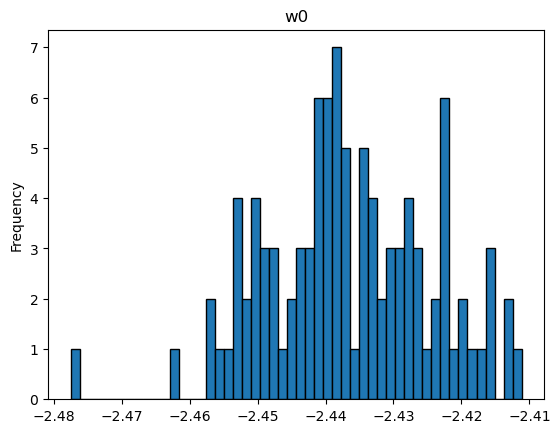

In [15]:
weights_df['w0'].plot.hist(bins=50, title='w0', edgecolor='black')

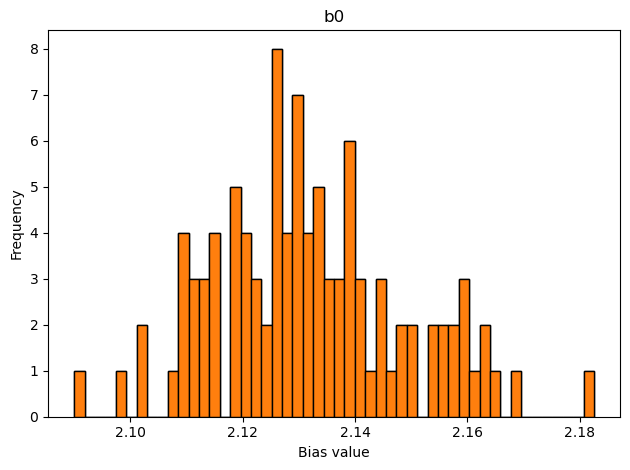

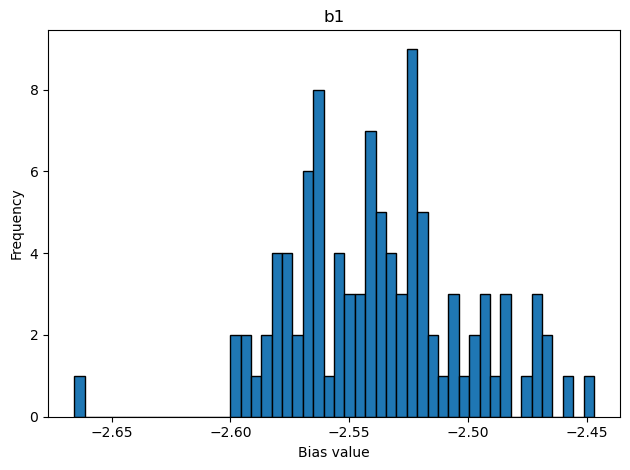

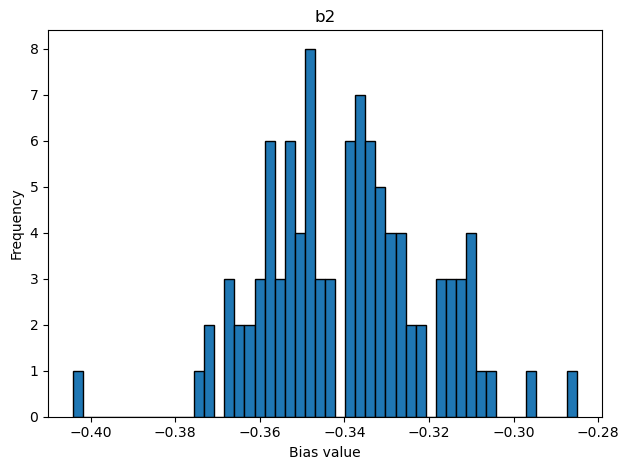

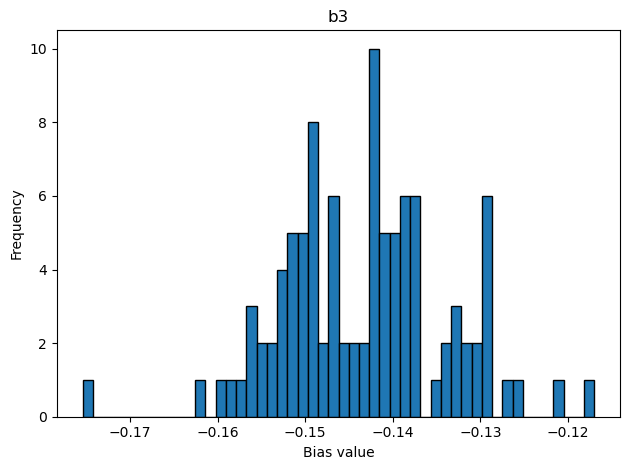

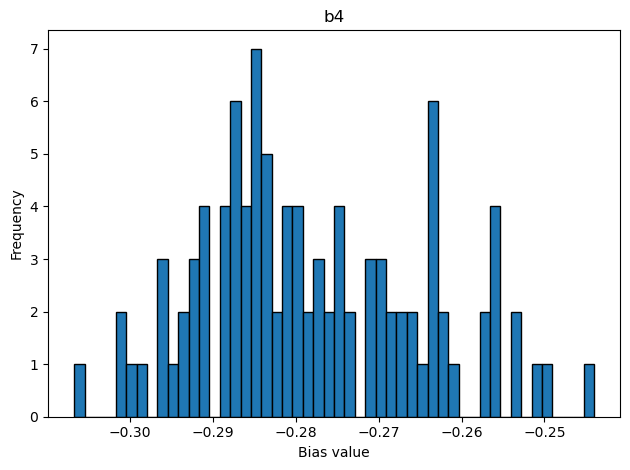

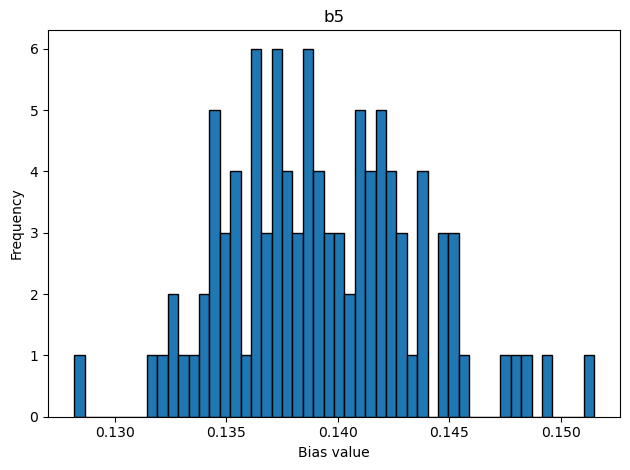

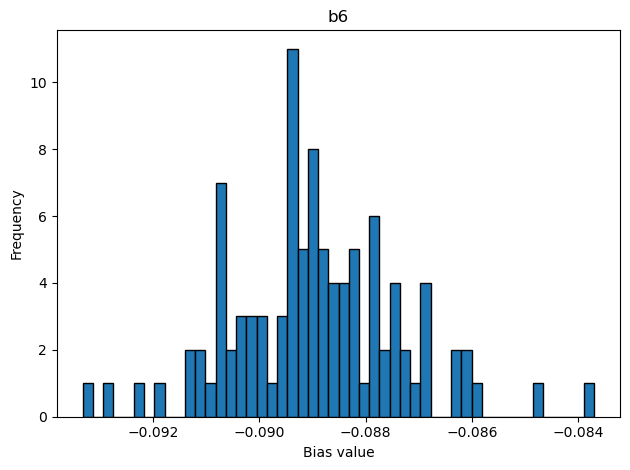

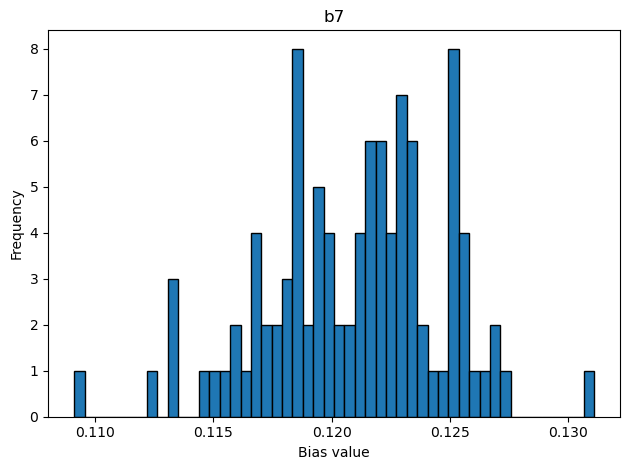

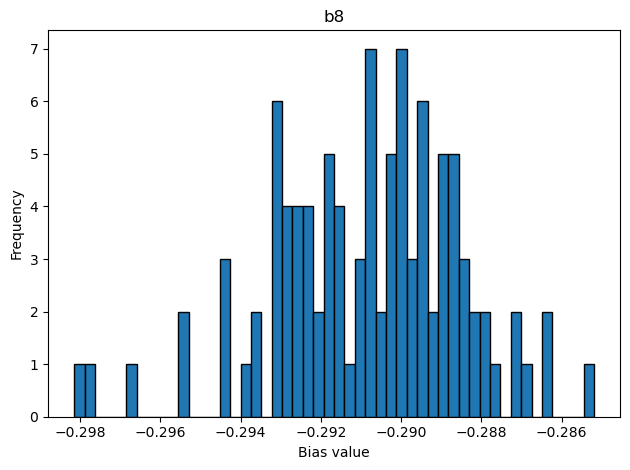

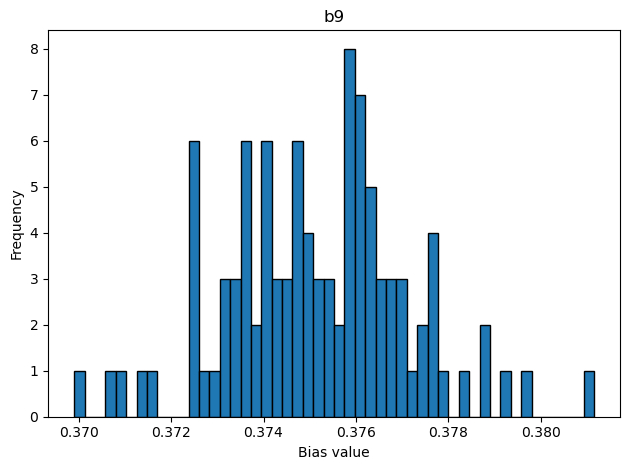

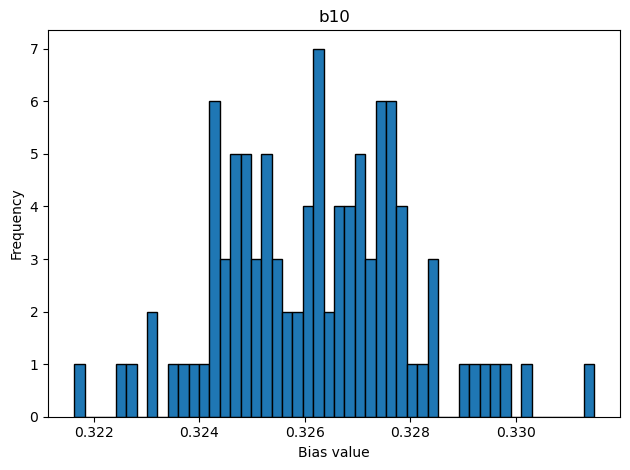

In [16]:
biases_df['b0'].plot.hist(bins=50, title='b0', edgecolor='black')

for col in biases_df.columns:
    ax = biases_df[col].plot.hist(bins=50, edgecolor='black')
    ax.set(title=col, xlabel="Bias value", ylabel="Frequency")
    plt.tight_layout()
    plt.show()


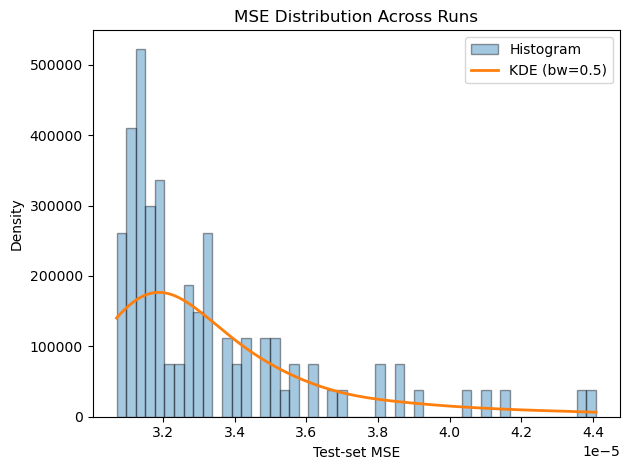

In [17]:
from scipy.stats import gaussian_kde

# load & normalize to 1D numpy array
err_path = Path("nn_distributions") / "errors_fwd.pkl"
mse_raw = pickle.load(open(err_path, "rb"))
mse = np.asarray(mse_raw).ravel()

# create figure & axes
fig, ax = plt.subplots()

# plot density‐scaled histogram
ax.hist(mse,
        bins=50,
        density=True,           # density scaled
        alpha=0.4,
        edgecolor="black",
        label="Histogram")

# compute & plot KDE
kde = gaussian_kde(mse, bw_method=0.5)
xs = np.linspace(mse.min(), mse.max(), 500)
ax.plot(xs, kde(xs),
        lw=2,
        label="KDE (bw=0.5)")

# labels & legend
ax.set_xlabel("Test‐set MSE")
ax.set_ylabel("Density")
ax.set_title("MSE Distribution Across Runs")
ax.legend()
plt.tight_layout()
plt.show()

Test-set MSE across runs:
count           100
mean    3.33184e-05
std     2.86255e-06
min     3.06968e-05
25%      3.1311e-05
50%     3.21853e-05
75%     3.43001e-05
max     4.40838e-05


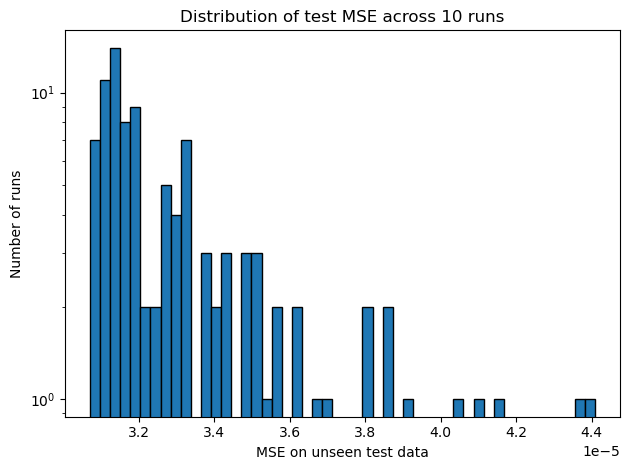

<Axes: ylabel='Density'>

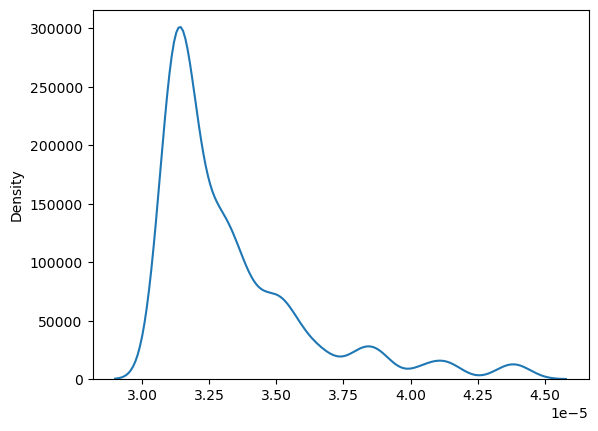

In [10]:
import seaborn as sns

# Load the test-losses (MSE)
err_path = OUT / "errors_fwd.pkl"
err_object = pickle.load(open(err_path, "rb"))

mse = pd.Series(err_object).apply(
    lambda v: float(np.squeeze(v))     # flatten & cast
).to_numpy()                           # → simple NumPy array

print("Test-set MSE across runs:")
print(pd.Series(mse).describe().to_string(float_format="%.6g"))


plt.figure()
plt.hist(
    mse,
    bins=50,
    edgecolor='black'
)
plt.yscale("log")
plt.xlabel("MSE on unseen test data")
plt.ylabel("Number of runs")
plt.title("Distribution of test MSE across 10 runs")   # adjust “10” if you run more
plt.tight_layout()
plt.show()

# save the figure alongside your pickles
# plt.savefig(OUT / "mse_histogram.png", dpi=300)
sns.kdeplot(mse, bw_adjust=0.5)


In [11]:
test_points = np.array([
    [np.pi/2],         # f(π/2)
    [np.sqrt(2)/2],    # f(√2 / 2)
])
preds = model.predict(test_points)
for x_val, y_hat in zip(test_points.flatten(), preds.flatten()):
    print(f"f({x_val:.4f}) ≈ {y_hat:.6f}")

NameError: name 'model' is not defined

In [ ]:
xs = np.linspace(0, 2*np.pi, 100)[:,None]
ys = model.predict(xs)

# Headinig

>this is my code


$RMSE = \sum (y-\hat{y})^2$